# JADEによるブラインド音源分離（ハンズオン）

## 1. 準備：ライブラリとアルゴリズムの読み込み
まずは必要な関数を定義します。

In [ ]:
# @title 1. システムの準備（ライブラリと関数の定義）
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, linalg
import librosa
from IPython.display import Audio, display
import io

try:
    from google.colab import files
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# --- 評価指標: Amari Index ---
def calc_amari_index(W, A):
    P = np.abs(W @ A)
    n = P.shape[0]
    row_sum = np.sum(P, axis=1)
    max_row = np.max(P, axis=1)
    term1 = np.sum((row_sum / max_row) - 1)
    col_sum = np.sum(P, axis=0)
    max_col = np.max(P, axis=0)
    term2 = np.sum((col_sum / max_col) - 1)
    return (term1 + term2) / (2 * n * (n - 1))

# --- JADE: 同時対角化関数 ---
def joint_diagonalization(matrices, threshold=1e-7, max_iter=100):
    M = np.array(matrices)
    n_matrices, n_dim, _ = M.shape
    V = np.eye(n_dim)
    for it in range(max_iter):
        max_off_diag = 0.0
        for p in range(n_dim):
            for q in range(p + 1, n_dim):
                g = M[:, p, q]
                h = M[:, p, p] - M[:, q, q]
                v1 = np.sum(h**2 - 4 * g**2)
                v2 = np.sum(4 * h * g)
                theta = 0.5 * np.arctan2(v2, v1 + np.sqrt(v1**2 + v2**2))
                c, s = np.cos(theta), np.sin(theta)
                M_p = M[:, p, :].copy(); M_q = M[:, q, :].copy()
                M[:, p, :] = c * M_p - s * M_q; M[:, q, :] = s * M_p + c * M_q
                M_p = M[:, :, p].copy(); M_q = M[:, :, q].copy()
                M[:, :, p] = c * M_p - s * M_q; M[:, :, q] = s * M_p + c * M_q
                V_p = V[:, p].copy(); V_q = V[:, q].copy()
                V[:, p] = c * V_p - s * V_q; V[:, q] = s * V_p + c * V_q
                max_off_diag = max(max_off_diag, np.max(np.abs(g)))
        if max_off_diag < threshold: break
    return V

# @title 結果の可視化（波形・散布図・凡例付き）
def plot_results(S, X, Y, fs, title_suffix=""):
    """
    S: 元信号 (Input)
    X: 混合信号 (Mixed)
    Y: 分離信号 (Recovered)
    fs: サンプリング周波数
    """
    # 描画設定: 3行3列
    fig, axes = plt.subplots(3, 3, figsize=(18, 12), constrained_layout=True)

    # データのリスト化
    data_list = [S, X, Y]
    titles = ["1. Input Data", "2. Mixed Data", "3. Recovered Data"]

    # Ch1のテーマカラー (青, オレンジ, 緑)
    colors_ch1 = ['#1f77b4', '#ff7f0e', '#2ca02c']
    # Ch2のテーマカラー (赤) - 視認性を高めるため固定
    color_ch2 = '#d62728'

    # ★修正点: 表示長さを0.03秒に変更
    n_samples = S.shape[1]
    time_limit = min(0.03, n_samples / fs)
    plot_len = int(time_limit * fs)
    time_axis = np.arange(plot_len) / fs

    step = max(1, n_samples // 5000) # 散布図の間引き

    for i, (data, title, col1) in enumerate(zip(data_list, titles, colors_ch1)):
        # --- 1段目: Ch1 波形 ---
        ax_t1 = axes[0, i]
        ax_t1.plot(time_axis, data[0, :plot_len], color=col1, linewidth=2, label='Ch 1')
        ax_t1.set_title(f"{title} - Ch 1", fontsize=14)
        ax_t1.set_ylabel("Amplitude")
        ax_t1.grid(True, linestyle=':', alpha=0.7)
        ax_t1.set_xlim(0, time_axis[-1])
        ax_t1.legend(loc='upper right')

        # --- 2段目: Ch2 波形 ---
        ax_t2 = axes[1, i]
        # ★修正点: Ch2を赤色にしてCh1と明確に区別
        ax_t2.plot(time_axis, data[1, :plot_len], color=color_ch2, linewidth=2, linestyle='-', label='Ch 2')

        ax_t2.set_title(f"{title} - Ch 2", fontsize=14)
        ax_t2.set_ylabel("Amplitude")
        ax_t2.set_xlabel("Time [s]")
        ax_t2.grid(True, linestyle=':', alpha=0.7)
        ax_t2.set_xlim(0, time_axis[-1])
        ax_t2.legend(loc='upper right')

        # --- 3段目: 散布図 (Joint Distribution) ---
        ax_j = axes[2, i]
        # 散布図はテーマカラー(Ch1の色)で統一
        ax_j.scatter(data[0, ::step], data[1, ::step], s=2, alpha=0.5, color=col1)

        # タイトルと軸ラベル
        dist_title = f"{title}\nJoint Distribution"
        if i == 2: dist_title += f"\n{title_suffix}"

        ax_j.set_title(dist_title, fontsize=14)

        labels = [['$s_1$', '$s_2$'], ['$x_1$', '$x_2$'], ['$y_1$', '$y_2$']]
        ax_j.set_xlabel(labels[i][0], fontsize=12)
        ax_j.set_ylabel(labels[i][1], fontsize=12)

        ax_j.axis('equal')
        ax_j.grid(True, linestyle=':', alpha=0.7)

    plt.suptitle("Blind Source Separation Demo (JADE)", fontsize=20)
    plt.show()

print("準備完了。次のセルへ進んでください。")

準備完了。次のセルへ進んでください。


## 2. 音源の選択 (Source Selection)
ここでデモの種類を選びます。

Synthetic Data: 数学的な正弦波とノコギリ波を生成します（理論解説用）。

Upload Audio: 手元のWAV/MP3ファイルを2つアップロードします（実践デモ用）。

In [ ]:
# @title 2. ソースデータの選択 (Hybrid Source) { run: "auto" }

# 選択肢を変更しました
source_type = "Synthetic Data (Only)" # @param ["Synthetic Data (Only)", "Hybrid (Real + Synthetic)"]
fs = 8000 # サンプリング周波数

if source_type == "Synthetic Data (Only)":
    # --- A. 人工データのみ (今まで通り) ---
    duration = 3.0
    t = np.linspace(0, duration, int(duration * fs))
    s1 = np.sin(2 * np.pi * 440 * t)           # 正弦波
    s2 = signal.sawtooth(2 * np.pi * 600 * t)  # ノコギリ波
    print(f"人工データを生成しました (長さ: {duration}秒)")

elif source_type == "Hybrid (Real + Synthetic)":
    # --- B. 実音声 + 人工シグナル ---
    print("音声ファイルを【1つだけ】アップロードしてください (wav, mp3など)")
    uploaded = files.upload()

    if len(uploaded) == 0:
        raise ValueError("ファイルがアップロードされませんでした。")

    filename = list(uploaded.keys())[0]

    # 1. アップロードされた音声を読み込み (Source 1)
    y1, _ = librosa.load(io.BytesIO(uploaded[filename]), sr=fs, mono=True)

    # 長すぎると計算が重いので、最大5秒にカット
    max_len = int(fs * 5.0)
    if len(y1) > max_len:
        y1 = y1[:max_len]
        print("※長いファイルのため、先頭5秒を使用します。")

    n_samples = len(y1)
    s1 = y1

    # 2. 人工的な干渉音を生成 (Source 2)
    # アップロードされた音声と同じ長さの「ノコギリ波 (ビープ音)」を作ります
    t = np.linspace(0, n_samples/fs, n_samples)
    s2 = signal.sawtooth(2 * np.pi * 440 * t) # 440Hzのブザー音

    # 3. 音量バランスの調整 (正規化)
    # 両方の音量が同じくらいになるように調整します
    s1 = (s1 - np.mean(s1)) / np.std(s1)
    s2 = (s2 - np.mean(s2)) / np.std(s2)

    print(f"ファイルを読み込み、人工ノイズと合成しました: {filename}")

# データをまとめる (共通処理)
S = np.vstack([s1, s2])

print("-" * 40)
print("▼ Source 1: Real Voice (or Uploaded Sound)")
display(Audio(s1, rate=fs))

print("▼ Source 2: Synthetic Interference (Sawtooth)")
display(Audio(s2, rate=fs))

人工データを生成しました (長さ: 3.0秒)
----------------------------------------
▼ Source 1: Real Voice (or Uploaded Sound)


▼ Source 2: Synthetic Interference (Sawtooth)


## 3. 混合シミュレーション (Mixing)選んだ2つの音源を、コンピュータ上で人工的に混ぜ合わせます。これが「カクテルパーティー効果」の状態です。$$\begin{pmatrix} x_1(t) \\ x_2(t) \end{pmatrix} = \begin{pmatrix} 0.8 & 0.4 \\ 0.3 & 0.9 \end{pmatrix} \begin{pmatrix} s_1(t) \\ s_2(t) \end{pmatrix}$$

In [ ]:
# 混合行列 (Mixer)
A_true = np.array([[0.8, 0.4],
                   [0.3, 0.9]])

# 観測信号 X = A * S
X = A_true @ S

print("▼ Mixed Audio (Mic 1 & 2) - 混ざった音を確認してください")
display(Audio(X[0], rate=fs))
display(Audio(X[1], rate=fs))

▼ Mixed Audio (Mic 1 & 2) - 混ざった音を確認してください


## 4. JADEアルゴリズムによる分離 (Separation)
ここが一瞬で終わりますが、裏側では「白色化」と「4次キュムラントの同時対角化」が行われています。

In [ ]:
# --- Step 1: 白色化 (Whitening) ---
X_mean = X.mean(axis=1, keepdims=True)
X_centered = X - X_mean
cov = np.cov(X_centered)
d, E = linalg.eigh(cov)

# ゼロ割対策
tau = 1e-12 * d.max()
d_safe = np.maximum(d, tau)
W_white = np.diag(1.0 / np.sqrt(d_safe)) @ E.T

Z = W_white @ X_centered

# --- Step 2: 4次キュムラント行列の計算 ---
n_ch, n_samples = X.shape
cum_matrices = []
I = np.eye(n_ch)

# 計算コスト削減のため間引きながら計算 (実データ対策)
skip = 1
if n_samples > 100000: skip = 10 # データが長すぎる場合は間引く

Z_calc = Z[:, ::skip]
for i in range(n_ch):
    for j in range(i, n_ch):
        coeffs = Z_calc[i, :] * Z_calc[j, :]
        Q_ij = (Z_calc * coeffs) @ Z_calc.T / Z_calc.shape[1]
        term1 = (1.0 if i == j else 0.0) * I
        e_i = I[:, i].reshape(-1, 1); e_j = I[:, j].reshape(-1, 1)
        term2 = e_i @ e_j.T; term3 = e_j @ e_i.T
        C_ij = Q_ij - term1 - term2 - term3
        cum_matrices.append(C_ij)

# --- Step 3: 同時対角化 (Joint Diagonalization) ---
U = joint_diagonalization(cum_matrices)

# --- Step 4: 復元 (Recovery) ---
W_est = U.T @ W_white
Y = W_est @ X_centered

# 評価 (Amari Index)
api = calc_amari_index(W_est, A_true)
print("分離完了！")

分離完了！


## 5. 結果の確認 (Results)
「波形」「散布図」「実際の音」で確認します。

Synthetic Dataの場合: 散布図がきれいな正方形に戻る様子を確認してください。

Upload Audioの場合: 散布図は複雑な形になりますが、直交した（独立した）軸が見て取れます。

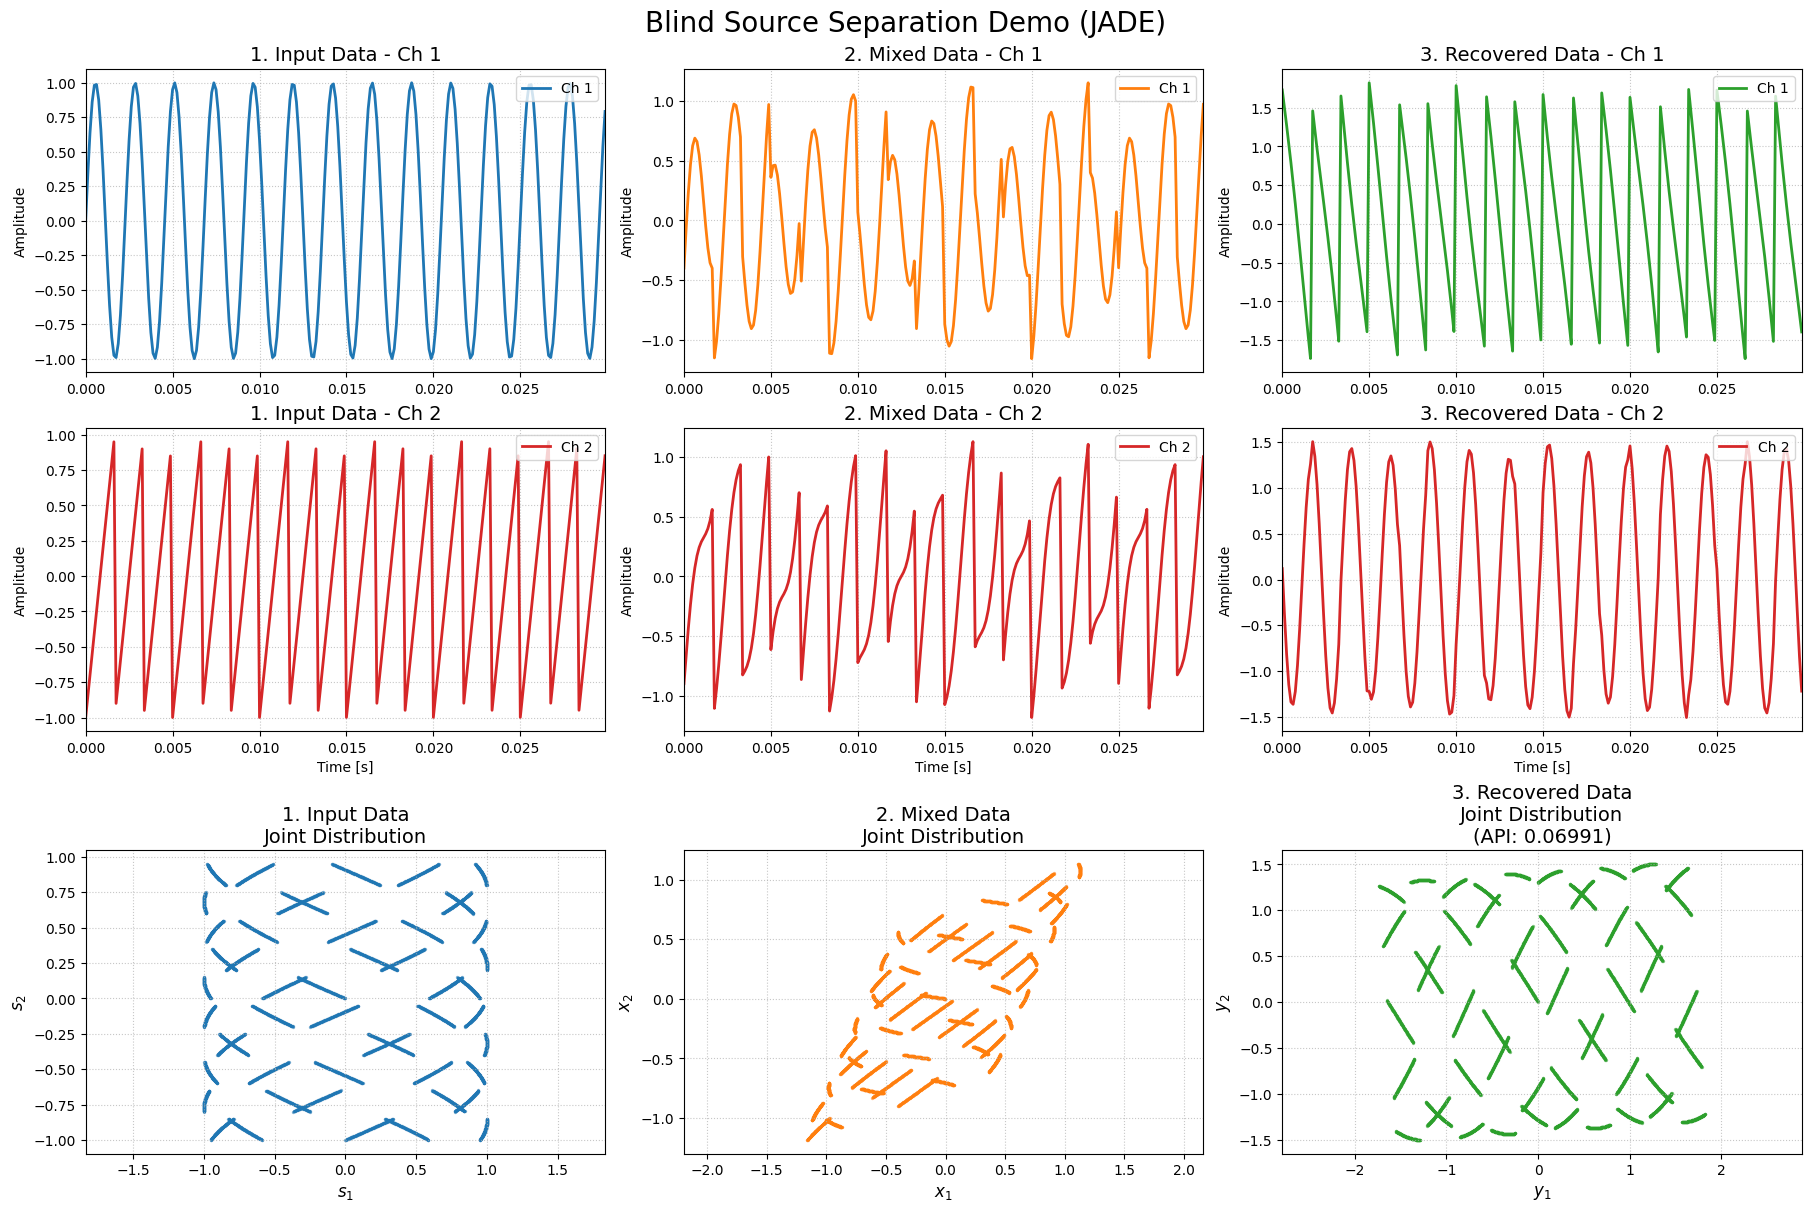

▼ Recovered Audio (Separated 1 & 2)


In [ ]:
# @title 5. 結果の確認 (Results)

# 結果のプロット (修正版の関数を呼び出し)
# 入力波形、混合波形、凡例付き
plot_results(S, X, Y, fs, title_suffix=f"(API: {api:.5f})")

# 音声再生
print("▼ Recovered Audio (Separated 1 & 2)")
display(Audio(Y[0], rate=fs))
display(Audio(Y[1], rate=fs))

---
### License & Copyright
**This software is released under the MIT License.**

<small>
Copyright (c) 2026 OGAWA Tomomi (Tokyo Denki University)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>

**Contact:** <small>to.ogawa[at]ms.dendai.ac.jp</small>